In [83]:
!pip install python_speech_features

In [84]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
import librosa as li
from tempfile import TemporaryFile
import os
import pickle
import random
import operator
import math
import numpy as np


In [85]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import pandas as pd

In [86]:
def distance(instance1 , instance2 , k ):
    distance =0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance+=(np.dot(np.dot((mm2-mm1).transpose() , np.linalg.inv(cm2)) , mm2-mm1 ))
    distance+= np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance-= k
    return distance

In [87]:
def getNeighbors(trainingSet, instance, k):
    distances = []
    for x in range (len(trainingSet)):
        dist = distance(trainingSet[x], instance, k )+ distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [88]:
def nearestClass(neighbors):
    classVote = {}

    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response]+=1
        else:
            classVote[response]=1

    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [89]:
def getAccuracy(testSet, predictions):
    correct = 0
    for x in range (len(testSet)):
        if testSet[x][-1]==predictions[x]:
            correct+=1
    return 1.0*correct/len(testSet)

In [90]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [91]:
%cd /content/drive/MyDrive/my_mus/

/content/drive/MyDrive/my_mus


In [92]:
import os
import pickle
import numpy as np
from scipy.io import wavfile
from python_speech_features import mfcc

directory = "/content/drive/MyDrive/my_mus/Data/genres_original/"
output_file_path = "my.dat"

with open(output_file_path, 'wb') as output_file:
    label = 0

    for folder in os.listdir(directory):
        label += 1

        if label == 11:
            break

        for file in os.listdir(os.path.join(directory, folder)):
            file_path = os.path.join(directory, folder, file)

            try:
                rate, sig = wavfile.read(file_path)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue

            mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
            covariance = np.cov(np.transpose(mfcc_feat))
            mean_matrix = np.mean(mfcc_feat, axis=0)
            feature = (mean_matrix, covariance, label)

            pickle.dump(feature, output_file)


The GTZAN dataset is the most-used public dataset for evaluation in machine listening research for music genre recognition (MGR). The files were collected in 2000-2001 from a variety of sources including personal CDs, radio, and microphone recordings, in order to represent a variety of recording conditions.

link: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

In [93]:
dataset = []
def loadDataset(filename , split , trSet , teSet):
    with open("my.dat" , 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break

    for x in range(len(dataset)):
        if random.random() <split :
            trSet.append(dataset[x])
        else:
            teSet.append(dataset[x])

trainingSet = []
testSet = []
loadDataset("my.dat" , 0.66, trainingSet, testSet)

In [94]:
leng = len(testSet)
predictions = []
for x in range (leng):
    predictions.append(nearestClass(getNeighbors(trainingSet ,testSet[x] , 5)))

accuracy1 = getAccuracy(testSet , predictions)
print(accuracy1)

0.6602564102564102


In [95]:
!pwd

/content/drive/MyDrive/my_mus


In [96]:
!python /content/drive/MyDrive/my_mus/test.py

defaultdict(<class 'int'>, {1: 'rock', 2: 'hiphop', 3: 'jazz', 4: 'country', 5: 'reggae', 6: 'metal', 7: 'pop', 8: 'disco', 9: 'blues', 10: 'classical'})
result: hiphop


In [97]:
data = pd.read_csv(f'/content/drive/MyDrive/my_mus/Data/features_3_sec.csv')
data = data.iloc[0:, 1:]
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [98]:
y = y[y.isin(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])] # genre variable.
X = data.loc[:, data.columns != 'label']
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [100]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [101]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

In [102]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

#Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")


Accuracy Naive Bayes : 0.51952 

Accuracy Stochastic Gradient Descent : 0.65532 

Accuracy KNN : 0.80581 

Accuracy Decission trees : 0.64665 

Accuracy Random Forest : 0.81415 

Accuracy Support Vector Machine : 0.75409 

Accuracy Logistic Regression : 0.6977 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [103]:
# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05,num_class=10)
model_assess(xgb, "Cross Gradient Booster")

Accuracy Cross Gradient Booster : 0.9009 



Accuracy : 0.9009 



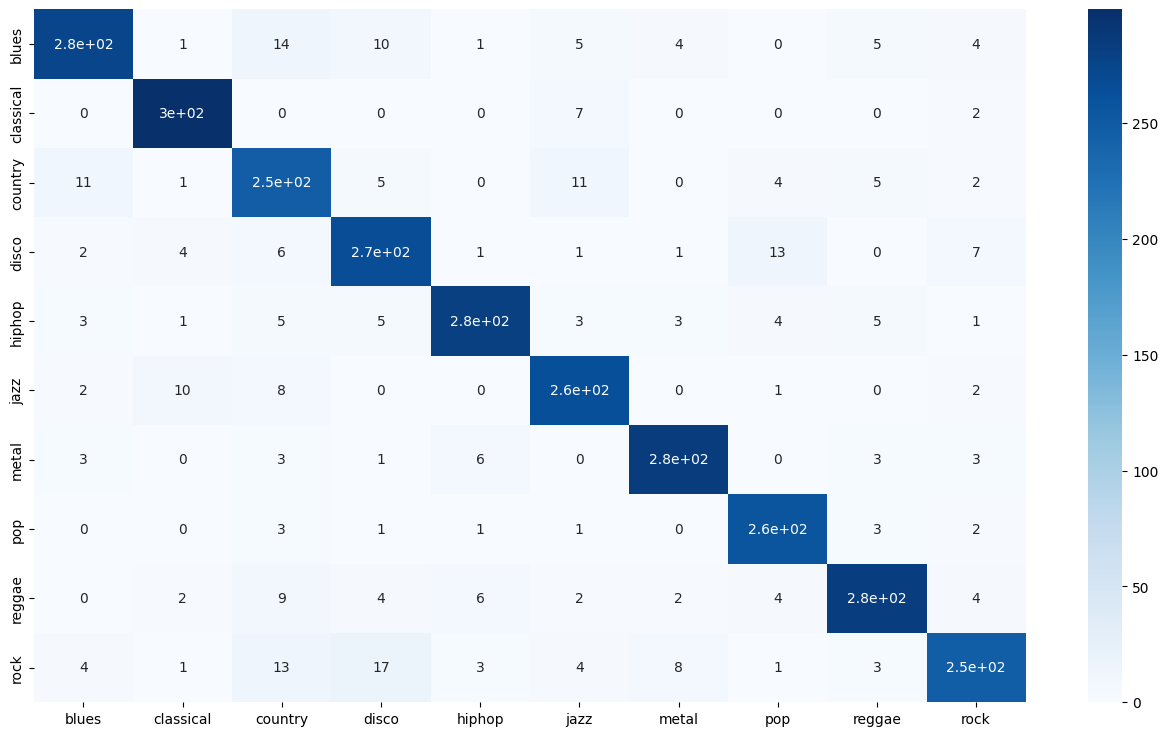

In [104]:
# Final model
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from IPython.display import Audio
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)


preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True,
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

In [105]:
import IPython.display as ipd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

# Read data
data = pd.read_csv(f'/content/drive/MyDrive/my_mus/Data/features_30_sec.csv', index_col='filename')

# Extract labels
labels = data[['label']]

# Drop labels from original dataframe
data = data.drop(columns=['length','label'])
data.head()

# Scale the data
data_scaled=preprocessing.scale(data)
print('Scaled data type:', type(data_scaled))

Scaled data type: <class 'numpy.ndarray'>


In [106]:
# Cosine similarity
similarity = cosine_similarity(data_scaled)
print("Similarity shape:", similarity.shape)

# Convert into a dataframe and then set the row index and column names as labels
sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names.head()

Similarity shape: (1000, 1000)


filename,blues.00000.wav,blues.00001.wav,blues.00002.wav,blues.00003.wav,blues.00004.wav,blues.00005.wav,blues.00006.wav,blues.00007.wav,blues.00008.wav,blues.00009.wav,...,rock.00090.wav,rock.00091.wav,rock.00092.wav,rock.00093.wav,rock.00094.wav,rock.00095.wav,rock.00096.wav,rock.00097.wav,rock.00098.wav,rock.00099.wav
filename,,,,,,,,,,,,,,,,,,,,,
blues.00000.wav,1.000000,0.049231,0.589618,0.284862,0.025561,-0.346688,-0.219483,-0.167626,0.641877,-0.097889,...,-0.082829,0.546169,0.578558,0.662590,0.571629,0.610942,0.640835,0.496294,0.284958,0.304098
blues.00001.wav,0.049231,1.000000,-0.096834,0.520903,0.080749,0.307856,0.318286,0.415258,0.120649,0.404168,...,-0.098111,-0.325126,-0.370792,-0.191698,-0.330834,-0.077301,-0.222119,-0.302573,0.499562,0.311723
blues.00002.wav,0.589618,-0.096834,1.000000,0.210411,0.400266,-0.082019,-0.028061,0.104446,0.468113,-0.132532,...,-0.032408,0.561074,0.590779,0.583293,0.514537,0.495707,0.566837,0.589983,0.216378,0.321069
blues.00003.wav,0.284862,0.520903,0.210411,1.000000,0.126437,0.134796,0.300746,0.324566,0.352758,0.295184,...,-0.320107,-0.206516,-0.151132,0.041986,-0.172515,-0.000287,0.020515,-0.107821,0.502279,0.183210
blues.00004.wav,0.025561,0.080749,0.400266,0.126437,1.000000,0.556066,0.482195,0.623455,0.029703,0.471657,...,0.087605,0.017366,0.138035,0.104684,-0.034594,0.063454,0.063546,0.172944,0.153192,0.061785


In [107]:
def find_similar_songs(name):
    # Find songs most similar to another song
    series = sim_df_names[name].sort_values(ascending = False)

    # Remove cosine similarity == 1 (songs will always have the best match with themselves)
    series = series.drop(name)

    # Display the 5 top matches
    print("\n*******\nSimilar songs to ", name)
    print(series.head(5))

In [108]:
find_similar_songs('hiphop.00099.wav')

ipd.Audio(f'/content/drive/MyDrive/my_mus/Data/genres_original/hiphop/hiphop.00099.wav')


*******
Similar songs to  hiphop.00099.wav
filename
hiphop.00063.wav    0.769755
hiphop.00062.wav    0.715698
hiphop.00004.wav    0.713017
hiphop.00075.wav    0.672967
reggae.00040.wav    0.666533
Name: hiphop.00099.wav, dtype: float64


Accuracy Naive Bayes: 0.52302

Accuracy Stochastic Gradient Descent: 0.65916

Accuracy KNN: 0.83133

Accuracy Decision Trees: 0.65215

Accuracy Random Forest: 0.81682

Accuracy Support Vector Machine: 0.75876



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Logistic Regression: 0.7012



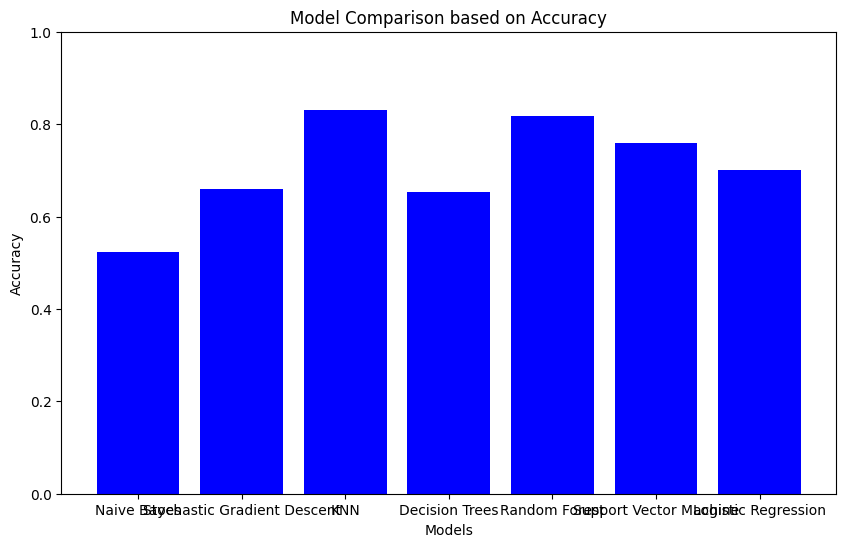

In [110]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Assuming X and y are your feature matrix and target variable
# Replace this with your actual data loading and preprocessing code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def model_assess(model, title="Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    print(f'Accuracy {title}: {round(accuracy, 5)}\n')
    return accuracy

# List of classifiers
classifiers = [
    ("Naive Bayes", GaussianNB()),
    ("Stochastic Gradient Descent", SGDClassifier(max_iter=5000, random_state=0)),
    ("KNN", KNeighborsClassifier(n_neighbors=19)),
    ("Decision Trees", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)),
    ("Support Vector Machine", SVC(decision_function_shape="ovo")),
    ("Logistic Regression", LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'))

]

# Evaluate and plot
accuracies = []
model_names = []

for title, model in classifiers:
    accuracy = model_assess(model, title)
    accuracies.append(accuracy)
    model_names.append(title)

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='blue')
plt.title('Model Comparison based on Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()


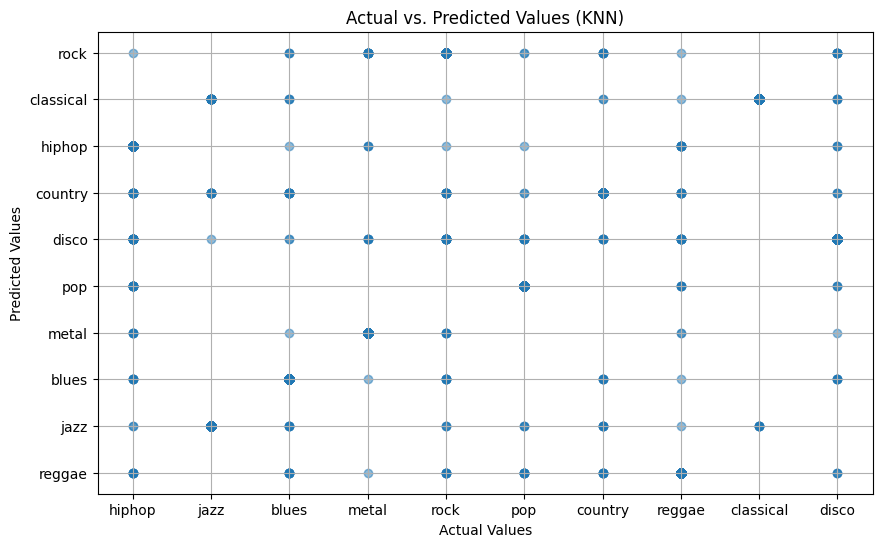

In [111]:
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Assuming X and y are your feature matrix and target variable
# Replace this with your actual data loading and preprocessing code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN model
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)

# Predictions
preds = knn.predict(X_test)

# Scatter plot of actual vs. predicted values for KNN
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds, alpha=0.5)
plt.title('Actual vs. Predicted Values (KNN)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


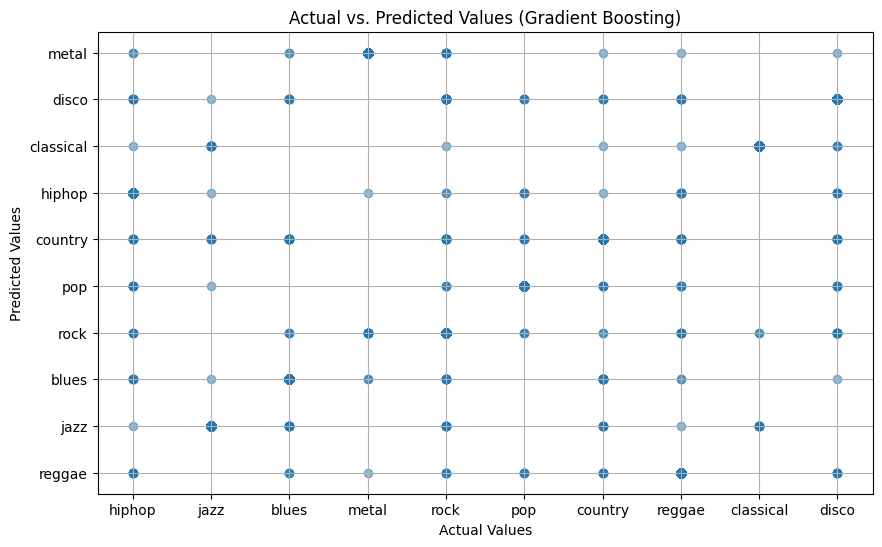

In [112]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assuming X and y are your feature matrix and target variable
# Replace this with your actual data loading and preprocessing code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
gb_preds = gb_model.predict(X_test)

# Scatter plot of actual vs. predicted values for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gb_preds, alpha=0.5)
plt.title('Actual vs. Predicted Values (Gradient Boosting)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:25:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


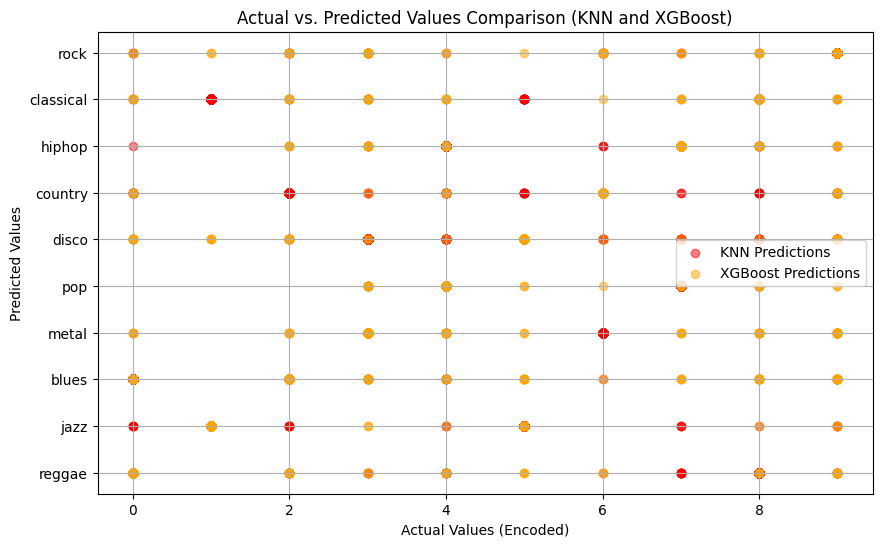

In [116]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Assuming X and y are your feature matrix and target variable
# Replace this with your actual data loading and preprocessing code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN model
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)

# XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, class_weight='balanced')
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Label encode target variable for better comparison
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Scatter plot for KNN and XGBoost only
plt.figure(figsize=(10, 6))

plt.scatter(y_test_encoded, knn_preds, alpha=0.5, label='KNN Predictions', color='red')
plt.scatter(y_test_encoded, xgb_preds, alpha=0.5, label='XGBoost Predictions', color='orange')

plt.title('Actual vs. Predicted Values Comparison (KNN and XGBoost)')
plt.xlabel('Actual Values (Encoded)')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:33:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


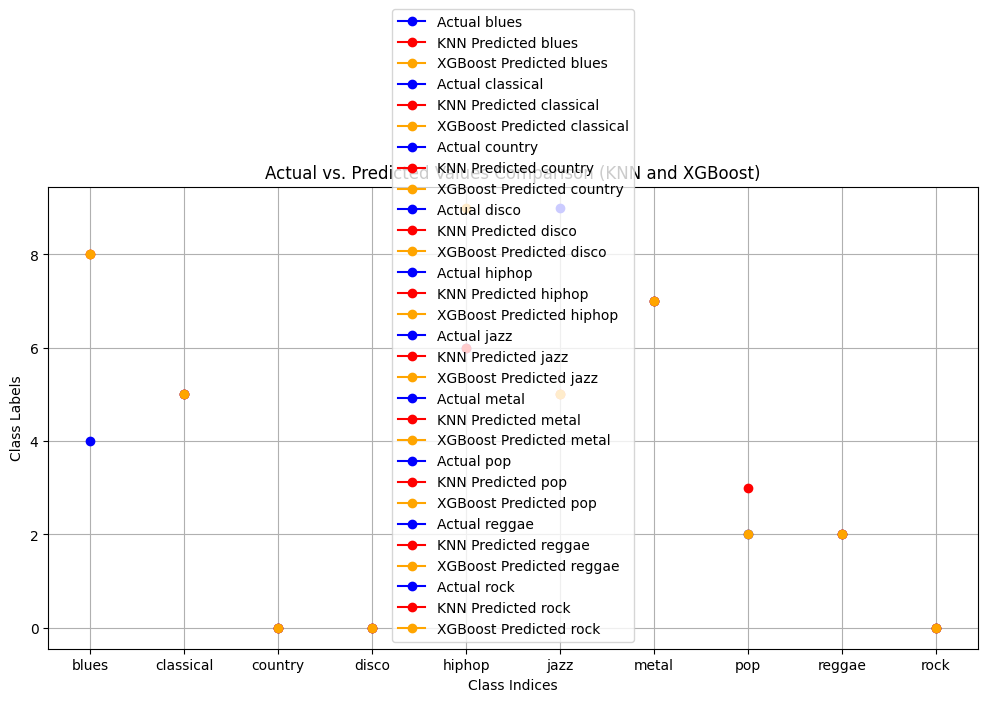

In [122]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming X and y are your feature matrix and target variable
# Replace this with your actual data loading and preprocessing code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Label encode target variable for better comparison
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# KNN model
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train_encoded)
knn_preds = knn.predict(X_test)

# XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, class_weight='balanced')
xgb_model.fit(X_train, y_train_encoded)
xgb_preds = xgb_model.predict(X_test)

# Prepare data for line plot
classes = label_encoder.classes_
num_classes = len(classes)
class_indices = np.arange(num_classes)

# Line plot for KNN and XGBoost actual vs. predicted values
plt.figure(figsize=(12, 6))

for i in range(num_classes):
    plt.plot(class_indices[i], y_test_encoded[i], marker='o', linestyle='-', label=f'Actual {classes[i]}', color='blue')
    plt.plot(class_indices[i], knn_preds[i], marker='o', linestyle='-', label=f'KNN Predicted {classes[i]}', color='red')
    plt.plot(class_indices[i], xgb_preds[i], marker='o', linestyle='-', label=f'XGBoost Predicted {classes[i]}', color='orange')

plt.title('Actual vs. Predicted Values Comparison (KNN and XGBoost)')
plt.xlabel('Class Indices')
plt.ylabel('Class Labels')
plt.xticks(class_indices, classes)
plt.legend()
plt.grid(True)

plt.show()

